# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('Training set', (55000, 28, 28, 1), (55000, 10))
('Validation set', (250, 28, 140, 1), (250, 5, 11))
('Test set', (250, 28, 140, 1), (250, 5, 11))
((50, 28, 140, 1), (50, 5, 11))


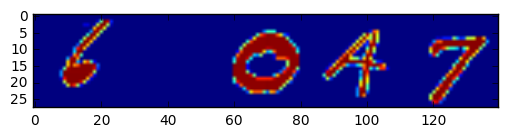

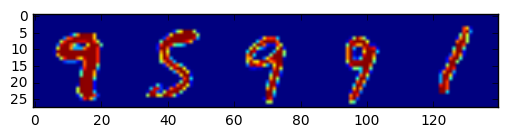

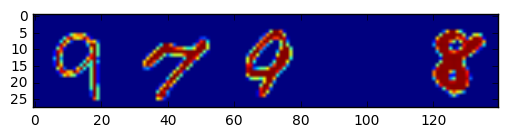

In [32]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))


def bias_variable(shape):
    return tf.Variable(tf.constant(1.0, shape=shape))


image_size = 28
num_channels = 1
num_labels = 11

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset, labels

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))/ predictions.shape[0])/5

train_dataset, train_labels = reformat(mnist.train.images, mnist.train.labels)
valid_dataset, valid_labels = reformat(mnist.validation.images, mnist.validation.labels)
test_dataset, test_labels = reformat(mnist.test.images, mnist.test.labels)

#synthesize images: merge 5 image to create 1 image
def merge_images(dataset,labels,num_images):
    total_images = dataset.shape[0]
    random_pos = np.random.randint(total_images,size=num_images)
    xs = dataset[random_pos]
    ys = labels[random_pos]
    ys = np.append(ys, np.zeros((num_images,1)), axis=1)

    #insert random number of blank spaces 
    replace_count = np.random.randint(3)
    for _ in range(replace_count):
        if np.random.randint(10) < 3:
            blank_pos = np.random.randint(0,4)
            xs[blank_pos] = np.zeros((28,28,1)).astype(np.float32)
            ys = np.delete(ys, (blank_pos), axis=0)
            ys = np.append(ys,np.zeros((1,11)),axis=0)
            ys[num_images-1][10] = 1
        
    concatanated_image = np.concatenate(xs, axis=1)
    return concatanated_image, ys

#create a set of merged images
def get_samples(num_samples):
    sample = []
    labels = []
    for i in xrange(num_samples):
        data, label = merge_images(train_dataset,train_labels,5)
        sample.append(data)
        labels.append(label)
    return np.array(sample), np.array(labels)

def create_validation_and_test():
    sample_valid_list = []
    labels_valid_list = []
    sample_test_list = []
    labels_test_list = []
    for i in xrange(250):
        merged_data_valid, merged_label_valid = merge_images(valid_dataset, valid_labels,5)
        merged_data_test, merged_label_test  = merge_images(test_dataset, test_labels,5)
        sample_valid_list.append(merged_data_valid)
        labels_valid_list.append(merged_label_valid)
        sample_test_list.append(merged_data_test)
        labels_test_list.append(merged_label_test)

    new_valid_dataset = np.array(sample_valid_list)
    new_valid_labels = np.array(labels_valid_list)
    new_test_dataset = np.array(sample_test_list)
    new_test_labels = np.array(labels_test_list)
    return (new_valid_dataset, new_valid_labels, new_test_dataset, new_test_labels)
valid_dataset, valid_labels, test_dataset, test_labels = create_validation_and_test()

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

sample = get_samples(50)
print(sample[0].shape, sample[1].shape)
for i in range(3):
    plt.imshow(sample[0][i].reshape((28,140)))
    plt.show()

In [34]:

batch_size = 50
patch_size = 5
depth = 128
num_hidden = 512
image_width = 140
image_height = 28


#build a graph
graph = tf.Graph()
with graph.as_default():
    #placeholder for input data and labels
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #create variables
    #Convolutions
    #layer1
    layer1_W = weight_variable([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_variable([depth])

    #layer2
    layer2_W = weight_variable([patch_size, patch_size, depth, depth])
    layer2_bias = bias_variable([depth])

    #layer3
    layer3_W = weight_variable([patch_size, patch_size, depth, depth])
    layer3_bias = bias_variable([depth])

    #Fully connected layers
    layer4_W = weight_variable([9216, num_hidden])
    layer4_bias = bias_variable([num_hidden])

    layer5_Ws = [weight_variable([num_hidden, num_labels]) for _ in xrange(5)]
    layer5_biases = [bias_variable([num_labels]) for _ in xrange(5)]


    #Model
    def model(data):
        conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_W, [1,2,2,1], padding='SAME') + layer1_bias)
        conv2 = tf.nn.relu(tf.nn.conv2d(conv1, layer2_W, [1,2,2,1], padding='SAME') + layer2_bias)
        conv3 = tf.nn.relu(tf.nn.conv2d(conv2, layer3_W, [1,2,2,1], padding='SAME') + layer3_bias)
        shape = conv3.get_shape().as_list()
        reshaped = tf.reshape(conv3, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden4 = tf.nn.relu(tf.matmul(reshaped, layer4_W) + layer4_bias)
        return [tf.matmul(hidden4, layer5_W) + layer5_bias for layer5_W, layer5_bias in zip(layer5_Ws, layer5_biases)]

    #A list of logits
    logits = model(tf_train_dataset)
    loss_per_digit = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[i],tf_train_labels[:,i,:])) for i in xrange(5)]
    loss = tf.add_n(loss_per_digit)

    #optimizer
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

    train_prediction = tf.transpose(tf.nn.softmax(logits), [1,0,2])
    valid_prediction = tf.transpose(tf.nn.softmax(model(tf_valid_dataset)), [1,0,2])
    test_prediction  = tf.transpose(tf.nn.softmax(model(tf_test_dataset)), [1,0,2])

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')

    for step in range(2501):
        batch = get_samples(batch_size)
        feed_dict = { tf_train_dataset: batch[0],
                      tf_train_labels: batch[1]}
        _,l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if step % 100 == 0:
            print('Minibatch accuracy at step {} : {}'.format(step, accuracy(predictions,  batch[1])))
            #print('Minibatch loss at step{}: {}'.format(step,l))
            print('Validation accuracy at step {}: {}'.format(step, accuracy(valid_prediction.eval(), valid_labels))) 

    print('Test accuracy is {}'.format(accuracy(test_prediction.eval(), test_labels)))




Initialized
Minibatch accuracy at step 0 : 9.2
Validation accuracy at step 0: 6.8
Minibatch accuracy at step 100 : 16.8
Validation accuracy at step 100: 17.68
Minibatch accuracy at step 200 : 34.0
Validation accuracy at step 200: 31.52
Minibatch accuracy at step 300 : 48.8
Validation accuracy at step 300: 47.52
Minibatch accuracy at step 400 : 56.0
Validation accuracy at step 400: 55.68
Minibatch accuracy at step 500 : 64.4
Validation accuracy at step 500: 60.56
Minibatch accuracy at step 600 : 64.8
Validation accuracy at step 600: 65.2
Minibatch accuracy at step 700 : 67.2
Validation accuracy at step 700: 68.16
Minibatch accuracy at step 800 : 69.2
Validation accuracy at step 800: 69.52
Minibatch accuracy at step 900 : 74.0
Validation accuracy at step 900: 72.32
Minibatch accuracy at step 1000 : 68.4
Validation accuracy at step 1000: 72.88
Minibatch accuracy at step 1100 : 79.2
Validation accuracy at step 1100: 74.88
Minibatch accuracy at step 1200 : 77.2
Validation accuracy at step 1

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer: There can be a blank space anywhere in the image, so I am using convolution layer to capture digits despite their spatial location. I am using relu activation function to have some non-linearity in the model. The final layer in the model is fully connected.  I am using a simpler version of the model used in   http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf paper.** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer: I am using 3 convulution layer with kernel size of 5*5. All the convolution layer has a stride of 2 so my spatial dimensions decreases by half after each layer. I am extracting 128 features from each layer. Then I am using 2 fully connected hidden layers. First fully connected hidden layer has 512 hidden nodes. Then the end I am using a list of 5 classification layer. All the layer has relu  as activation function except the softmax classifier.**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:I am picking 5 random images from MNIST dataset to merge. Then I am randomly replacing the digits with 0s to include spaces in the image. The labels have 11 classes (10 numbers and 1 space). I am classifying spaces only in end. After 2500 epochs the model gets an accuracy of 89%. I tried Adam optimizer and gradient descent optimizer. AdamOptimizer converges faster than GradientDescentOptimizer.  The learning rate for Adam optimizer is 0.001. Higher learning rate than this caused increase in loss and model was not converging.**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [35]:
import tarfile
import h5py
import os.path
import numpy as np
import cPickle as pickle
from os import listdir
from PIL import Image
from six.moves.urllib.request import urlretrieve

path='train/'
url = "http://ufldl.stanford.edu/housenumbers/"
metadata = {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def maybe_download(filename, path, expected_bytes):
    """Download and extract file if not present in the current directory"""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url+filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
        with tarfile.open(filename) as f:
            f.extractall()
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify' + filename)
    return filename

maybe_download("train.tar.gz", 'train/', 404141560)

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
            metadata[name].append(vals)

f = h5py.File('train/digitStruct.mat')
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

pickle_file = path+'metadata.pickle'
try:
    with open(pickle_file, 'wb') as pf:
        pickle.dump(metadata, pf)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise


def one_hot_encode(labels):
    b = np.zeros((len(labels), 6, 11))
    b[:, :, 10] = 1
    for img_num in range(len(labels)):
        for index, num in enumerate(labels[img_num]):
            b[img_num, index, num] = 1
            b[img_num, index, 10] = 0
    return b


def pad_list(l):
    y = np.array([x + [0] * (6 - len(x)) for x in l])
    return y


def get_bounding_box_as_array(metadata, offset, batch_size):
    for key in metadata:
        metadata[key] = pad_list(metadata[key][offset:offset+batch_size])
    bbox = np.zeros((batch_size, 6, 4))

    bbox[:, :, 0] = metadata['top']
    bbox[:, :, 1] = metadata['left']
    bbox[:, :, 2] = metadata['height']
    bbox[:, :, 3] = metadata['width']
    return bbox


def get_train_data(path, offset, batch_size):
    with open(path + 'metadata.pickle', 'rb') as f:
        metadata = pickle.load(f)

    if not os.path.isfile(path+'imagelist.pickle'):
        imagelist = filter(lambda x: 'png' in x, listdir(path))
        imagelist = sorted(imagelist, key=lambda x: int(filter(str.isdigit, x)))
        
        with open(path+'imagelist.pickle', 'wb') as f:
            pickle.dump(imagelist, f)
    else:
        with open(path+'imagelist.pickle', 'rb') as f:
            imagelist = pickle.load(f)

    loaded_images = []
    for image in imagelist[offset:offset+batch_size]:
        with Image.open(path+image) as img:
            img = img.convert('L').resize((128, 32), Image.BILINEAR)
            im = np.asarray(img)
            loaded_images.append(im.reshape(128, 32, 1))

    ytrain = metadata['label'][offset:offset+batch_size]
    ytrain = one_hot_encode(ytrain)
    bbox = get_bounding_box_as_array(metadata, offset, batch_size)
    return np.array(loaded_images), np.array(ytrain), bbox



Found and verified train.tar.gz


In [37]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import numpy as np

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))


def bias_variable(shape):
    return tf.Variable(tf.constant(1.0, shape=shape))


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))/ predictions.shape[0])/6

offset = 0

image_height = 32
image_width = 128
num_channels = 1
num_labels = 11
num_digits = 6

batch_size = 128
patch_size = 5
depth = 256
num_hidden1 = 2048
num_hidden2 = 512

Xvalidation, yvalidation, _ = get_train_data('train/',offset,batch_size)
offset += batch_size
Xtest, ytest, _ = get_train_data('train/', offset, batch_size)
offset += batch_size

#print dimensions
print("Xvalidation shape is {} and yvalidation shape is {}".format(Xvalidation.shape, yvalidation.shape))

#build a graph
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, num_channels))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_digits, num_labels))
    tf_valid_dataset = tf.cast(tf.constant(Xvalidation),tf.float32)
    tf_test_dataset = tf.cast(tf.constant(Xtest), tf.float32)

    #Create variables
    #convolutions layer 1
    layer1_W = weight_variable([patch_size, patch_size, num_channels, depth//2])
    layer1_bias = bias_variable([depth//2])

    #layer2
    layer2_W = weight_variable([patch_size, patch_size, depth//2, depth//2])
    layer2_bias = bias_variable([depth//2])

    #layer3
    layer3_W = weight_variable([patch_size, patch_size, depth//2, depth])
    layer3_bias = bias_variable([depth])

    #layer3a
    layer3a_W = weight_variable([patch_size, patch_size, depth, depth])
    layer3a_bias = bias_variable([depth])

    #layer3
    layer3c_W = weight_variable([patch_size, patch_size, depth, depth])
    layer3c_bias = bias_variable([depth])
    

    #layer 4
    layer4_W = weight_variable([image_height//8*image_width//8*depth, num_hidden1])
    layer4_bias = bias_variable([num_hidden1])

    layer4a_W = weight_variable([num_hidden1, num_hidden2])
    layer4a_bias = bias_variable([num_hidden2])
    #layer 5
    layer5_Ws = [weight_variable([num_hidden2, num_labels]) for _ in xrange(num_digits)]
    layer5_biases = [bias_variable([num_labels]) for _ in xrange(num_digits)]

    #Design model
    def model(data):
        conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_W, [1,2,2,1], padding='SAME') + layer1_bias)
        conv2 = tf.nn.relu(tf.nn.conv2d(conv1, layer2_W, [1,2,2,1], padding='SAME') + layer2_bias)
        conv3 = tf.nn.relu(tf.nn.conv2d(conv2, layer3_W, [1,2,2,1], padding='SAME') + layer3_bias)
        conv3a = tf.nn.relu(tf.nn.conv2d(conv3, layer3a_W, [1,1,1,1], padding='SAME') + layer3a_bias)
        conv3c = tf.nn.relu(tf.nn.conv2d(conv3a, layer3c_W, [1,1,1,1], padding='SAME') + layer3c_bias)
        shape = conv3c.get_shape().as_list()
        reshaped = tf.reshape(conv3c, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden1 = tf.nn.relu(tf.matmul(reshaped, layer4_W) + layer4_bias)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, layer4a_W) + layer4a_bias)
        return [tf.matmul(hidden2, layer5_W) + layer5_bias for layer5_W, layer5_bias in zip(layer5_Ws, layer5_biases)]

    logits = model(tf_train_dataset)
    loss_per_digit = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[i], tf_train_labels[:,i,:])) for i in xrange(num_digits)]
    loss = tf.add_n(loss_per_digit)

    #optimizer
    global_step = tf.Variable(0,trainable=False)
    starter_learning_rate = 0.005
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,5,0.90,staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)
    train_prediction = tf.transpose(tf.nn.softmax(logits), [1,0,2])
    validation_prediction = tf.transpose(tf.nn.softmax(model(tf_valid_dataset)), [1,0,2])
    test_prediction = tf.transpose(tf.nn.softmax(model(tf_test_dataset)), [1, 0, 2])

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    

    for step in range(250):
        batch_data, batch_label,_ = get_train_data('train/',offset,batch_size)
        offset += batch_size
        feed_dict = { tf_train_dataset: batch_data,
                      tf_train_labels : batch_label }
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if step % 50 == 0:
            print('Minibatch accuracy at step {} : {} and loss is {} '.format(step, accuracy(predictions, batch_label),l))
            print('Validation accuracy is {}'.format(accuracy(validation_prediction.eval(), yvalidation)))
    
    print('Test accuracy is {}'.format(accuracy(test_prediction.eval(), ytest)))


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Xvalidation shape is (128, 128, 32, 1) and yvalidation shape is (128, 6, 11)
Initialized
Minibatch accuracy at step 0 : 1.82291666667 and loss is 3597335.75 
Validation accuracy is 65.3645833333
Minibatch accuracy at step 50 : 61.1979166667 and loss is 47.7926673889 
Validation accuracy is 62.6302083333
Minibatch accuracy at step 100 : 63.4114583333 and loss is 17.2731075287 
Validation accuracy is 66.5364583333
Minibatch accuracy at step 150 : 63.671875 and loss is 9.75918006897 
Validation accuracy is 67.96875
Minibatch accuracy at step 200 : 67.8385416667 and loss is 7.04691362381 
Validation accuracy is 67.3177083333
Test accuracy is 65.7552083333


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:I am using PIL library to resize images to 32*128. I am seperating two batches of images from training set and using them as validation and test set. The model which I used for classification of synthesized MNIST data performed very poorly on this SVHN datset. So I increased the complexity by using more convolution layers. The model quickly reaches accuracy of 66% and it does not improve thereafter. The model only learns to output blank spaces in the end.**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:I increased the complexity of the model by adding more layers and using exponentially decaying learning rate. I increased the number of convolution and fully-connected layers. I also increased the number of nodes in fully connected layer. Decaying learning rate is also not helping much in improving the model's accuracy and loss. Earlier the model was giving accuracy 62% and now the model is giving an accuracy of 69%. I think the model only learns to predict 'blank' digits.**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer: Initially the model's accuracy was around 0 as I was using 32x32 images for single digit classification. By using multidigit classification with full images and adding back 6 classification layers the model's accuracy improved to 60%. Increasing  the complexity of the model only improved accuracy by 8-9%. I don't think that the model has learnt to predict digits. **

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [41]:
import matplotlib.pyplot as plt
### Your code implementation goes here.
### Feel free to use as many code cells as needed.
def get_camera_images():
    imagelist = listdir('camera-pic/')
    loaded_images = []
    for image in imagelist:
        with Image.open('camera-pic/'+image) as img:
            img = img.convert('L').resize((128, 32), Image.BILINEAR)
            plt.figure()
            plt.imshow(img)
            im = np.asarray(img)
            loaded_images.append(im.reshape(128, 32, 1))
    return np.array(loaded_images)


with graph.as_default():
    tf_camera_data = tf.cast(tf.constant(get_camera_images()), tf.float32)
    
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    camera_image_pred = tf.nn.softmax(model(tf_camera_data))
    
    print('Camera result is\n {}'.format(np.argmax(camera_image_pred.eval(), 2)))


Camera result is
 [[5 5 5 2 5]
 [0 0 0 0 0]
 [9 9 9 9 9]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [0 1 1 1 1]]


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:There are 2 images in the camera dataset which are too wide. These images can be difficult to classify.**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:The model is doing a very poor job in classification of digits on captured images. The classification accuracy of the model on real images and on test set of svhn data are 0. The model is definately not learning anything with this model.**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [47]:
import tensorflow as tf
import numpy as np
import cv2


def weight_var(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='Weight')


def bias_var(shape):
    return tf.Variable(tf.constant(1.0, shape=shape), name='bias')


def accuracy(pred, labels):
    return (100.0 * np.sum(
        np.argmax(pred, 2) == np.argmax(labels, 2)) / pred.shape[0])/6


def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.histogram('histogram', var)


def conv2d(data, wt, bias, stride=[1, 2, 2, 1]):
    variable_summaries(wt)
    variable_summaries(bias)
    return tf.nn.dropout(tf.nn.relu(tf.nn.conv2d(data, wt, stride, padding='SAME', name='convolution') + bias,
                                    name='relu'), 0.80, name='dropout')


offset = 0
image_height = 32
image_width = 128
num_channels = 1
num_labels = 11
num_digits = 6

batch_size = 64
patch_size = 5
depth = 32
num_hidden1 = 1024
reg_hidden1 = 1024
reg_hidden2 = 512

Xvalid, yvalid, bbox_valid = get_train_data('train/', offset, batch_size)
offset += batch_size
Xtest, ytest, bbox_test = get_train_data('train/', offset, batch_size)
offset += batch_size


# print dimensions
print("Xvalid shape is {} and yvalid shape is {} and bbox is {}"
      .format(Xvalid.shape, yvalid.shape, bbox_valid.shape))
print('y is \n{}\nbbox is \n{}'
      .format(yvalid[0], bbox_valid[0]))

# build a graph
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size,
                           image_width, image_height, num_channels))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_digits, num_labels))
    tf_valid_dataset = tf.cast(tf.constant(Xvalid), tf.float32)
    tf_train_bbox = tf.placeholder(tf.float32,
                                   shape=(batch_size, num_digits, 4))
    tf_test_dataset = tf.cast(tf.constant(Xtest), tf.float32)
    tf_camera_data = tf.cast(tf.constant(get_camera_images()), tf.float32)

    # Create variables
    # convolutions layer 1
    layer1_W = weight_var([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_var([depth])

    # layer2
    layer2_W = weight_var([patch_size, patch_size, depth, depth*2])
    layer2_bias = bias_var([depth*2])

    # layer3
    layer3_W = weight_var([patch_size, patch_size, depth*2, depth*2])
    layer3_bias = bias_var([depth*2])

    # layer4
    layer4_W = weight_var([patch_size, patch_size, depth*2, depth*2])
    layer4_bias = bias_var([depth*2])

    # layer5
    layer5_W = weight_var([patch_size, patch_size, depth*2, depth*2])
    layer5_bias = bias_var([depth*2])

    # convolution layer 6
    layer6_W = weight_var([patch_size, patch_size, depth*2, depth*4])
    layer6_bias = bias_var([depth*4])

    # convolution layer 7
    layer7_W = weight_var([patch_size, patch_size, depth*4, depth*4])
    layer7_bias = bias_var([depth*4])

    # Regression head
    fc1_reg_W = weight_var([image_height//16*image_width//16*depth*4, reg_hidden1])
    fc1_reg_bias = bias_var([reg_hidden1])

    fc2_reg_W = weight_var([reg_hidden1, reg_hidden2])
    fc2_reg_bias = bias_var([reg_hidden2])

    fc3_reg_Ws = [weight_var([reg_hidden2, 4]) for _ in range(num_digits)]
    fc3_reg_biases = [bias_var([4]) for _ in range(num_digits)]

    # Classification head
    c1_W = weight_var([image_height//16*image_width//16*depth*4, num_hidden1])
    c1_bias = bias_var([num_hidden1])

    c3_Ws = [weight_var([num_hidden1, num_labels])
             for _ in range(num_digits)]
    c3_biases = [bias_var([num_labels]) for _ in range(num_digits)]

    # Design model
    def model(data):
        with tf.name_scope('conv1'):
            conv1 = conv2d(data, layer1_W, layer1_bias)
        with tf.name_scope('conv2'):
            conv2 = conv2d(conv1, layer2_W, layer2_bias)
        with tf.name_scope('conv3'):
            conv3 = conv2d(conv2, layer3_W, layer3_bias)
        with tf.name_scope('conv4'):
            conv4 = conv2d(conv3, layer4_W, layer4_bias, stride=[1, 1, 1, 1])
        with tf.name_scope('conv5'):
            conv5 = conv2d(conv4, layer5_W, layer5_bias, stride=[1, 1, 1, 1])
        with tf.name_scope('conv6'):
            conv6 = conv2d(conv5, layer6_W, layer6_bias)
        with tf.name_scope('conv7'):
            conv7 = conv2d(conv6, layer7_W, layer7_bias, stride=[1, 1, 1, 1])
        with tf.name_scope('reshape'):
            shape = conv7.get_shape().as_list()
            reshaped = tf.reshape(conv7, [shape[0], shape[1] * shape[2] * shape[3]])

        # Regression head for bounding box prediction
        with tf.name_scope('reg1'):
            reg1 = tf.nn.relu(tf.matmul(reshaped, fc1_reg_W) + fc1_reg_bias)
        with tf.name_scope('reg2'):
            reg2 = tf.nn.relu(tf.matmul(reg1, fc2_reg_W) + fc2_reg_bias)
        with tf.name_scope('reg_list'):
            bbox_pred = [tf.matmul(reg2, fc3_reg_W) + fc3_reg_bias
                     for fc3_reg_W, fc3_reg_bias in zip(fc3_reg_Ws, fc3_reg_biases)]
        with tf.name_scope('transpose'):
            bbox_pred = tf.transpose(tf.pack(bbox_pred), [1, 0, 2])

        # classification head
        with tf.name_scope('classify1'):
            hidden1 = tf.nn.relu(tf.matmul(reshaped, c1_W) + c1_bias)
        with tf.name_scope('classify_list'):
            logits = tf.pack([tf.matmul(hidden1, c3_W) + c3_bias
                          for c3_W, c3_bias in zip(c3_Ws, c3_biases)])
            logits = tf.transpose(logits, [1, 0, 2])
        return logits, bbox_pred

    logits, train_bbox_pred = model(tf_train_dataset)
    loss_per_digit = [tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits[:, i, :], tf_train_labels[:, i, :]))
                      for i in range(num_digits)]
    with tf.name_scope('loss'):
        loss = tf.add_n(loss_per_digit, name='loss')
        bbox_loss = tf.nn.l2_loss(train_bbox_pred - tf_train_bbox, name='reg_loss')

    tf.summary.scalar('loss', loss)
    tf.summary.scalar('bbox_loss', bbox_loss)
    merged = tf.summary.merge_all()
    train_writer = tf.train.SummaryWriter('log', graph)

    # optimizer
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.005
    learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                               global_step, 5, 0.90,
                                               staircase=True)
    optimizer = tf.train.AdamOptimizer(
        learning_rate).minimize(loss, global_step=global_step)
    bbox_optimizer = tf.train.AdamOptimizer(
        learning_rate).minimize(bbox_loss, global_step=global_step)

    # Predictions
    valid_logits, valid_bbox_pred = model(tf_valid_dataset)
    test_logits, test_bbox_pred = model(tf_test_dataset)
    camera_logits, camera_bbox_pred = model(tf_camera_data)
    train_pred = tf.nn.softmax(logits)
    valid_pred = tf.nn.softmax(valid_logits)
    test_pred = tf.nn.softmax(test_logits)
    camera_image_pred = tf.nn.softmax(camera_logits)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')

    for step in range(301):
        batch_data, batch_label, bbox = get_train_data('train/', offset, batch_size)
        offset += batch_size
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_label,
                     tf_train_bbox: bbox}
        _, l, predictions, _, bbox_cost, summary = session.run(
            [optimizer, loss, train_pred, bbox_optimizer, bbox_loss, merged],
            feed_dict=feed_dict)
        train_writer.add_summary(summary, i)
        if step % 10 == 0:
            print('Minibatch accuracy at step {} : {} and loss is {}'.format(
                step, accuracy(predictions, batch_label), l))
            print('Validation accuracy is {}'.format(
                accuracy(valid_pred.eval(), yvalid)))
            print('Regression loss at {} is {}'.format(step, bbox_cost))

    print('Test accuracy is \n{}'.format(accuracy(test_pred.eval(), ytest)))
    camera_label_pred =  camera_image_pred.eval()
    camera_bbox = camera_bbox_pred.eval()
    print('Camera result is \n{} and bbox is \n{}'.format(
        np.argmax(camera_label_pred, 2), camera_bbox))
    

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Xvalid shape is (64, 128, 32, 1) and yvalid shape is (64, 6, 11) and bbox is (64, 6, 4)
y is 
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
bbox is 
[[  77.  246.  219.   81.]
 [  81.  323.  219.   96.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Initialized
Minibatch accuracy at step 0 : 3.64583333333 and loss is 710241.125
Validation accuracy is 67.96875
Regression loss at 0 is 5.07448236442e+12
Minibatch accuracy at step 10 : 51.3020833333 and loss is 29.4352340698
Validation accuracy is 55.9895833333
Regression loss at 10 is 1974196.625
Minibatch accuracy at

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer: The model is doing a very poor job at predicting the bounding box. The loss for bounding box prediction is very high and is not converging. Regression head is not affecting classification accuracy. The model is giving same output every time.**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:Bounding box is for images are negative which is not possible. The model is not able to localize in image.**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.